# Projet Dengue

Projet issu d'une compétition de [DrivenData](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

La dengue est une maladie transmise par les moustiques qui survient dans les régions tropicales et subtropicales du monde. Dans les cas bénins, les symptômes sont similaires à ceux de la grippe: fièvre, éruption cutanée ou encore douleurs musculaires et articulaires. Dans les cas graves, la dengue peut provoquer des saignements graves, une hypotension artérielle et même la mort.

Parce qu'elle est portée par les moustiques, la dynamique de transmission de la dengue est liée à des variables climatiques telles que la température et les précipitations. Bien que la relation avec le climat soit complexe, un nombre croissant de scientifiques soutiennent que le changement climatique est susceptible de produire des changements de distribution qui auront des implications importantes pour la santé publique dans le monde entier.

Ces dernières années, la dengue s'est propagée. Historiquement, la maladie a été la plus répandue en Asie du Sud-Est et dans les îles du Pacifique. De nos jours, la plupart des près de 500 millions de cas par an se produisent en Amérique latine.

Dans ces zones, les schémas de transmission saisonniers sont ponctués par des épidémies beaucoup plus importantes à un interval de quelques années. Étant donné l'imprévisibilité des ces épidémies et leurs conséquences majeures pour les populations touchées, l'objectif de ce proje est de déterminer quels en sont les facteurs clés.

https://www.healthmap.org/dengue/en/index.php

# Description des données

Les données sont des données historiques de surveillance pour deux sites endémiques: Iquitos au Pérou et San Juan à Porto Rico. Elles se composent du nombre de cas hebdomadaires de dengue confirmés en laboratoire depuis l'année 2000 pour Iquitos et l'année 1990 pour San Juan.
Elles proviennent du site web de l'administrationn nationale des océans et de l'atmosphère :


https://dengueforecasting.noaa.gov/

In [62]:
#!pip install string

In [63]:
import pandas as pd
import numpy as np
import random
from string import ascii_letters
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
%matplotlib inline

In [64]:
features_train = pd.read_csv('data/dengue_features_train.csv')
labels_train = pd.read_csv('data/dengue_labels_train.csv')
features_test = pd.read_csv('data/dengue_features_test.csv')

### Regrouper features et label :

In [65]:
features = list(features_train)
label = ['total_cases']

In [66]:
df = features_train.merge(labels_train, how='left', left_on=['city', 'year','weekofyear'], right_on = ['city', 'year','weekofyear'])
DATA = df.copy()  #On crée un copie permanente, en cas d'altération de notre 1er dataframe
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


# Rajout des données de population :

In [67]:
pop_gen = pd.read_csv('data/pop_gen_processed.csv')

In [68]:
df = df.merge(pop_gen, how='left', left_on=['city','year'], right_on=['city','year'])
features_test = features_test.merge(pop_gen, how='left', left_on=['city','year'], right_on=['city','year'])
df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,373459,3015
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,373459,3015
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,373459,3015
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,373459,3015
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,373459,3015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5,447467,1212
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8,447467,1212
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1,447467,1212
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1,447467,1212


# Exploration des données

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 27 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [70]:
df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137,405313.557692,2471.619505
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000,16362.343166,1001.147129
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000,373459.000000,1048.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000,395459.000000,1166.000000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000,404194.000000,3157.000000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000,412095.000000,3258.500000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000,447467.000000,3335.000000


In [71]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
# df_iq.hist(bins=50, figsize=(20,15), ax=axes[0])
# df_sj.hist(bins=50, figsize=(20,15), ax=axes[1])
# fig.tight_layout()

Plotter les années en focntuion du nombre d ecas

In [72]:
df_iq = df[df['city']=='iq'].sort_values(by=['week_start_date'])
df_sj = df[df['city']=='sj'].sort_values(by=['week_start_date'])

In [73]:
df_iq.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density
count,520.000000,520.000000,517.000000,517.000000,517.000000,517.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,483.000000,483.000000,506.000000,512.000000,504.000000,520.000000,520.000000,520.000000
mean,2005.000000,26.503846,0.263869,0.238783,0.250126,0.266779,64.245736,297.869538,299.133043,295.492982,307.082752,292.866667,57.609864,88.639117,64.245736,17.096110,9.206783,27.530933,10.566197,34.004545,21.196680,62.467262,7.565385,417908.150000,1132.400000
std,2.918283,15.029450,0.081370,0.076751,0.077354,0.086345,35.218995,1.170997,1.332073,1.417229,2.382980,1.663069,50.286555,7.583889,35.218995,1.445769,2.448525,0.921769,1.535496,1.325261,1.260327,63.245958,10.765478,17729.115037,47.940168
min,2000.000000,1.000000,0.061729,0.035860,0.029880,0.064183,0.000000,294.635714,294.892857,290.088571,300.000000,286.900000,0.000000,57.787143,0.000000,12.111429,3.714286,21.400000,5.200000,30.100000,14.700000,0.000000,0.000000,386666.000000,1048.000000
25%,2002.750000,13.750000,0.200000,0.179540,0.194743,0.204129,39.105000,297.092500,298.221429,294.593929,305.200000,291.975000,24.065000,84.295000,39.105000,16.102857,7.371429,27.000000,9.500000,33.200000,20.600000,17.200000,1.000000,404433.500000,1095.750000
50%,2005.000000,26.500000,0.263643,0.232971,0.249800,0.262143,60.470000,297.822857,299.121429,295.852143,307.050000,293.050000,46.440000,90.917143,60.470000,17.428571,8.964286,27.600000,10.625000,34.000000,21.300000,45.300000,5.000000,418168.000000,1133.000000
75%,2007.250000,39.250000,0.319971,0.293929,0.302300,0.325150,85.757500,298.649286,300.123214,296.548571,308.700000,294.200000,71.072500,94.563929,85.757500,18.180357,11.014286,28.100000,11.655000,34.900000,22.000000,85.950000,9.000000,431747.250000,1170.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,210.830000,301.637143,302.928571,298.450000,314.000000,296.000000,362.030000,98.610000,210.830000,20.461429,16.028571,30.800000,15.800000,42.200000,24.200000,543.300000,116.000000,447467.000000,1212.000000


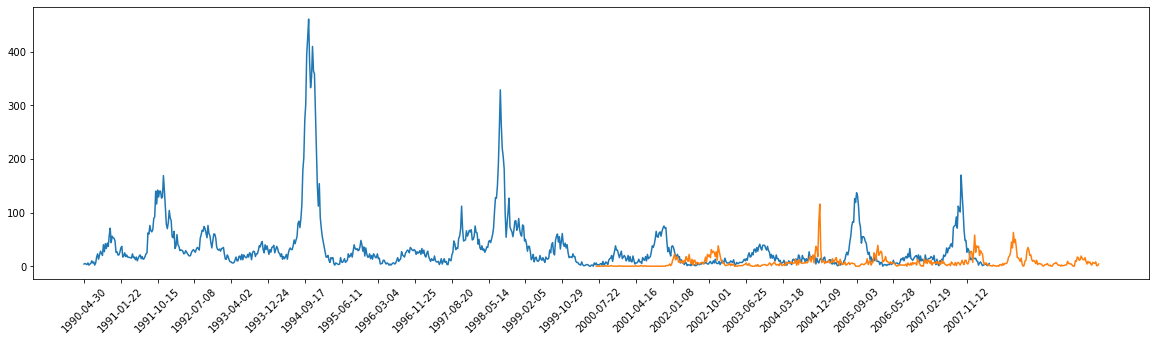

In [74]:
plt.figure(figsize=(20, 5))
plt.plot(df_sj['week_start_date'], df_sj["total_cases"])
plt.plot(df_iq['week_start_date'], df_iq["total_cases"])
plt.xticks(df_sj['week_start_date'], rotation=45)
plt.locator_params(axis='x', nbins=25)
plt.show()

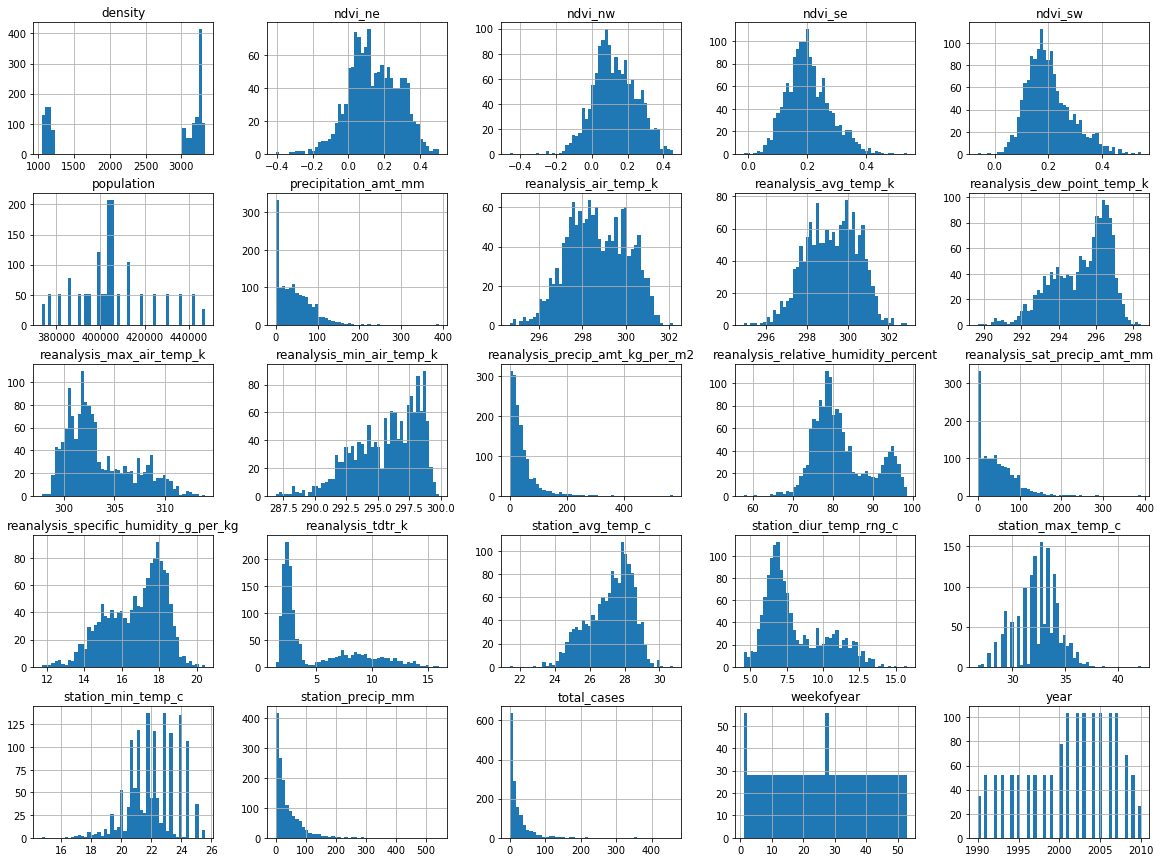

In [75]:
#Projection des données globales :
df.hist(bins=50, figsize=(20,15))
plt.show()

In [76]:
#Projection des données pour la ville de San Juan :
# df_sj = df[df['city']=="sj"]
# df_sj.hist(bins=50, figsize=(20,15))
# plt.show()

In [77]:
#Projection des données pour la ville de Iquitos :
# df_iq = df[df['city']=="iq"]
# df_iq.hist(bins=50, figsize=(20,15))
# plt.show()

<div class="alert alert-danger">
On remarque une anomalie pour les semaines de l'année :

In [78]:
week = df[df["weekofyear"]==1][["city","year","weekofyear","week_start_date"]]
print(len(week))

28


In [79]:
week = df[df["weekofyear"]==2][["city","year","weekofyear","week_start_date"]]
print(len(week))

28


In [80]:
week = df[df["weekofyear"]==0][["city","year","weekofyear","week_start_date"]]
print(len(week))

0


# Nettoyage des données

On met week_start_date au bon format :

 A changer en numérique éventuellement  
 - Pour le moment on préfère juste le supprimer

In [81]:
#df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df = df.drop(['week_start_date'], axis=1)
features_test = features_test.drop(['week_start_date'], axis=1)

In [82]:
df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,373459,3015
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,373459,3015
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,373459,3015
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,373459,3015
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,373459,3015


# Combler les trous de données

On a que très peu de données manquante, toutes les colonnes ont au moins 1400 données sur les 1456 au max. On remplace donc tous les trous par la médiane, plus robuste aux outliers éventuels.

In [83]:
#df.info()

In [84]:
features_test

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,population,density
0,sj,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,399025,3221
1,sj,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,399025,3221
2,sj,2008,20,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,399025,3221
3,sj,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,399025,3221
4,sj,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,399025,3221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0,462783,1254
412,iq,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0,462783,1254
413,iq,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2,462783,1254
414,iq,2013,25,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1,462783,1254


In [85]:
#On crée un dataframe avec toutes les données numériques (sans city)
df_num = df.drop(['city'], axis=1)
features_test_num = features_test.drop(['city'], axis=1)

features_test_cols = features_test.columns

In [86]:
#On comble les NaNs avec un KNN :
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

features_cols_num = features_test_num.columns
features_test_num_treated = imputer.fit_transform(features_test_num)
features_test_num_treated = pd.DataFrame(features_test_num_treated, columns = features_cols_num)

df_num_treated = imputer.fit_transform(df_num)
df_num_treated = pd.DataFrame(df_num_treated, columns = df_num.columns)
df_num_treated.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,373459.0,3015.0
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,373459.0,3015.0
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0,373459.0,3015.0
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0,373459.0,3015.0
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0,373459.0,3015.0


In [87]:
#On rajoute la colonne non-numérique city
dffffff = pd.concat([df_num_treated, df[['city']] ], axis=1)
features_test = pd.concat([features_test_num_treated, features_test[['city']] ], axis=1)
#dffffff = df_num_treated.copy()
#features_test = features_test_num_treated.copy()

#reorder columns as before
df = dffffff[df.columns]
features_test = features_test[features_test_cols]

# Feature Engineering

### Correlation matrix :

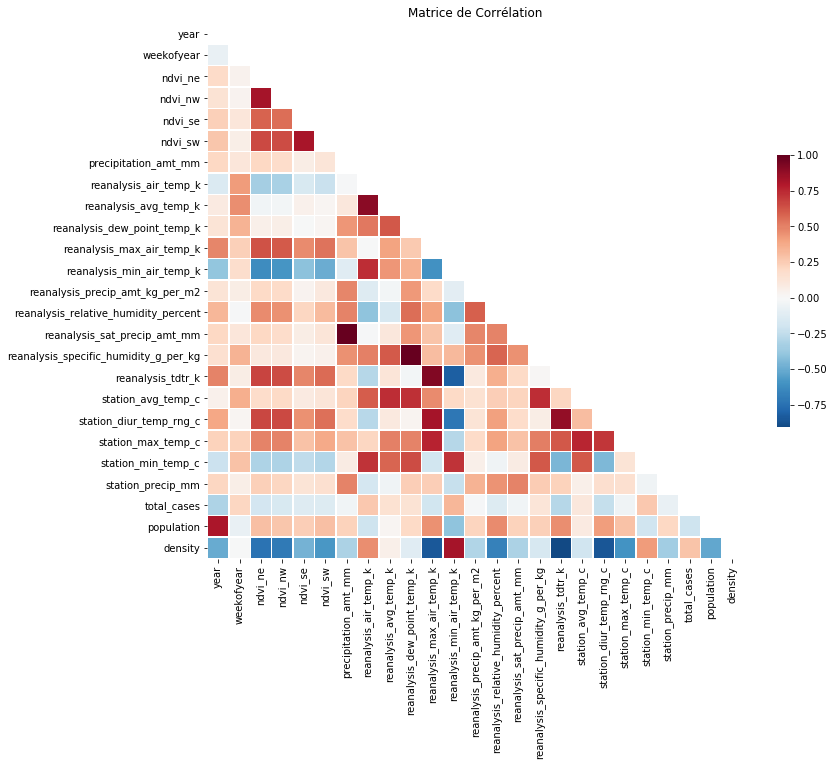

In [88]:
corrMatrix = df.corr()

fig = plt.figure(figsize=(12,10))

#Mask for the uppertriangle
mask = np.zeros_like(corrMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrMatrix, mask = mask, cmap="RdBu_r", square= True, linewidths=0.5,cbar_kws={"shrink": 0.5}, center = 0)
plt.title("Matrice de Corrélation")
plt.show()

### Correlation with Total_Cases :

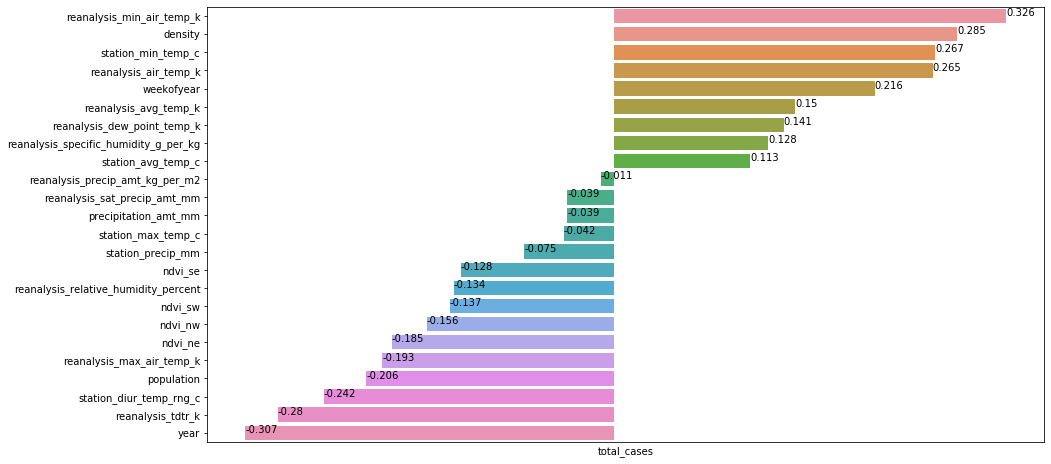

In [89]:
fig = plt.figure(figsize = (15,8))
cor_tot_cases = corrMatrix['total_cases'].sort_values(ascending = False).drop('total_cases')
ax = sns.barplot(cor_tot_cases, cor_tot_cases.index)

for index, value in enumerate(cor_tot_cases):
    ax.text(value, index, round(value,3))

plt.xticks([])
plt.show()

### Suppression de Dew_point_temp_k

On supprime reanalysis_dew_point_temp_k car il est très très corrélé à reanalysis_specific_humidity_g_per_kg, ce qui fait de la redondance d'information, ce n'est pas très bon.

In [90]:
df = df.drop(['reanalysis_dew_point_temp_k'], axis=1)

<div class="alert alert-info">
On supprime year pour voir :

# Autocorrélation

On rajoute la valeur du nombre de cas précédent, afin d'avoir une meilleure idée du rythme de propagation.

In [91]:
df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density
0,sj,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,373459.0,3015.0
1,sj,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,373459.0,3015.0
2,sj,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0,373459.0,3015.0
3,sj,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0,373459.0,3015.0
4,sj,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0,373459.0,3015.0


In [92]:
target = df_iq["total_cases"].copy()
df_iq["week-1"] = target.shift(+1)
#df_iq["week-2"] = target.shift(+2)
                     
target = df_sj["total_cases"].copy()
df_sj["week-1"] = target.shift(+1)
#df_sj["week-2"] = target.shift(+2)

In [93]:
df = pd.concat([df_iq, df_sj])
df = df.fillna(0)
df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density,week-1
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0,386666,1048,0.0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0,386666,1048,0.0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0,386666,1048,0.0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0,386666,1048,0.0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0,386666,1048,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4,399025,3221,3.0
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3,399025,3221,4.0
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1,399025,3221,3.0
934,sj,2008,16,2008-04-15,0.001800,0.000000,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3,399025,3221,1.0


# NDVI

On essaye de combiner les ndvi en une seule colonne:

In [94]:
cols = list(df)
cols.insert(3, "NDVI")
df["NDVI"] = df[["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"]].mean(axis=1)
df = df[cols]
df = df.drop(["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"], axis=1)

In [95]:
cols = list(features_test)
cols.insert(3, "NDVI")
features_test["NDVI"] = features_test[["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"]].mean(axis=1)
features_test = features_test[cols]
features_test = features_test.drop(["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"], axis=1)
features_test.head()

,city,year,weekofyear,NDVI,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,population,density
0,sj,2008.0,18.0,0.039032,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,399025.0,3221.0
1,sj,2008.0,19.0,0.030989,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,399025.0,3221.0
2,sj,2008.0,20.0,0.090073,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,399025.0,3221.0
3,sj,2008.0,21.0,0.075690,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,399025.0,3221.0
4,sj,2008.0,22.0,0.058704,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,399025.0,3221.0


### [Variables catégorielles](https://www.datacamp.com/community/tutorials/categorical-data)

La seule variable catégorielle est city.    

On choisit :
- **0 pour Iquitos**
- **1 pour San Juan**

In [96]:
#On remplace pour les données d'entrainement ET de test :
replace_dict = {'city': {'iq': 0, 'sj': 1}}
features_test.replace(replace_dict, inplace=True)
df.replace(replace_dict, inplace=True)
#Supprime aussi reanalysis_dew_point_temp_k
df = df.drop(['reanalysis_dew_point_temp_k'], axis=1)
df.head()

,city,year,weekofyear,NDVI,week_start_date,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density,week-1
936,0,2000,26,0.228307,2000-07-01,25.41,296.740000,298.450000,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0,386666,1048,0.0
937,0,2000,27,0.256012,2000-07-08,60.61,296.634286,298.428571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0,386666,1048,0.0
938,0,2000,28,0.170504,2000-07-15,55.52,296.415714,297.392857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0,386666,1048,0.0
939,0,2000,29,0.206918,2000-07-22,5.60,295.357143,296.228571,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0,386666,1048,0.0
940,0,2000,30,0.316546,2000-07-29,62.76,296.432857,297.635714,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0,386666,1048,0.0


# Modèles de Machine Learning :

Premier Random Forest en baseline.  
Pratique car pas besoin de manipulations supplémentaires, comme la normalisation des données.  
Donc on peut le lancer immédiatement :

Enlever l'année ne change pas du tout la prédiction alors que c'était le premier indicateur, on doit avoir un biais dans les données, c'est très bizarre...  
Par contre sans l'année, city redevient un bon indicateur du résultat.

### Création de jeu de test et d'entraînement :

In [97]:
df = df.drop(['week_start_date'], axis=1)  #catégoriel, non utilisable pour les algos

In [98]:
df.head()

,city,year,weekofyear,NDVI,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density,week-1
936,0,2000,26,0.228307,25.41,296.740000,298.450000,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0,386666,1048,0.0
937,0,2000,27,0.256012,60.61,296.634286,298.428571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0,386666,1048,0.0
938,0,2000,28,0.170504,55.52,296.415714,297.392857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0,386666,1048,0.0
939,0,2000,29,0.206918,5.60,295.357143,296.228571,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0,386666,1048,0.0
940,0,2000,30,0.316546,62.76,296.432857,297.635714,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0,386666,1048,0.0


Pour test et train, on coupe dans le temps, on prend²

In [99]:
years_iq = df[df['city']==0.0]['year'].astype('category').cat.categories.tolist()
years_sj = df[df['city']==1.0]['year'].astype('category').cat.categories.tolist()

In [100]:
n_iq = 7 #7 premières années sur 11
n_sj = 14 #14 premières années sur 19

#Train
train_iq = df[(df['city']==0.0) & ( df['year'].isin(years_iq[:n_iq]))]
train_sj = df[(df['city']==1.0) & ( df['year'].isin(years_sj[:n_sj]))]
X_train = pd.concat([train_iq, train_sj]).drop(['total_cases'], axis=1)
y_train = pd.concat([train_iq, train_sj])[['total_cases']]

#Test
test_iq = df[(df['city']==0.0) & ( df['year'].isin(years_iq[n_iq:]))]
test_sj = df[(df['city']==1.0) & ( df['year'].isin(years_sj[n_sj:]))]
X_test = pd.concat([test_iq, test_sj]).drop(['total_cases'], axis=1)
y_test = pd.concat([test_iq, test_sj])[['total_cases']]

In [101]:
X_train.shape

(1049, 22)

In [102]:
X_test.shape

(407, 22)

In [103]:
y_train.shape

(1049, 1)

<div class="alert alert-info">
On supprime year pour voir :

In [104]:
X_train = X_train.drop(['year'], axis=1)
X_test = X_test.drop(['year'], axis=1)

# Comparaison de différents Modèles

In [105]:
def test_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.rint(y_pred)
    score = round(mean_absolute_error(y_test, y_pred), 3)
    return(score)

In [106]:
dumb = DummyClassifier(strategy="stratified")
lg = LinearRegression()
ridge = linear_model.Ridge()
lasso = linear_model.Lasso(alpha=0.03)
knn = neighbors.KNeighborsRegressor(n_neighbors = 9)
svr = SVR()
rf = RandomForestRegressor(100)
xgb = xgboost.XGBRegressor(n_estimator = 200, silent = True)

score_dumb = test_model(dumb, X_train, y_train, X_test, y_test)
score_lg = test_model(lg, X_train, y_train, X_test, y_test)
score_ridge = test_model(ridge, X_train, y_train, X_test, y_test)
score_lasso = test_model(lasso, X_train, y_train, X_test, y_test)
score_knn = test_model(knn, X_train, y_train, X_test, y_test)
score_rf = test_model(rf, X_train, y_train, X_test, y_test)
score_svr = test_model(svr, X_train, y_train, X_test, y_test)
score_xgb = test_model(xgb, X_train, y_train, X_test, y_test)

importances_rf = np.asarray(rf.feature_importances_)
importances_xgb = np.asarray(xgb.feature_importances_)

print([score_dumb, score_lg, score_ridge, score_lasso, score_knn, score_rf, score_svr, score_xgb])

C:\Users\axeld\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38537.094537734774, tolerance: 249.9302627264061
  positive)
C:\Users\axeld\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\axeld\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[26.568, 5.781, 5.838, 5.855, 12.027, 5.943, 12.764, 5.646]


# Choix de XGBoost

In [107]:
xgb = xgboost.XGBRegressor(n_estimator = 200, silent = True)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred = np.rint(y_pred)

score = round(mean_absolute_error(y_test, y_pred), 3)
score

5.646

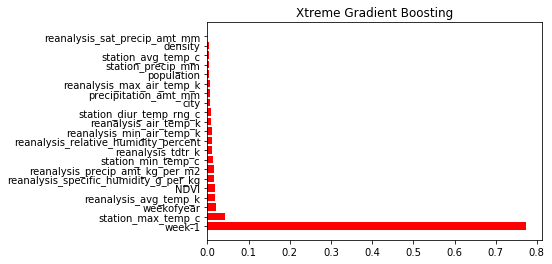

In [108]:
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange features names so they match the sorted feature importances
names = [list(X_train)[i] for i in indices]

# Create plot
plt.figure()
plt.title("Xtreme Gradient Boosting")
plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

# Soumission

In [109]:
features_test

,city,year,weekofyear,NDVI,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,population,density
0,1,2008.0,18.0,0.039032,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,399025.0,3221.0
1,1,2008.0,19.0,0.030989,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,399025.0,3221.0
2,1,2008.0,20.0,0.090073,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,399025.0,3221.0
3,1,2008.0,21.0,0.075690,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,399025.0,3221.0
4,1,2008.0,22.0,0.058704,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,399025.0,3221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0,2013.0,22.0,0.336329,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0,462783.0,1254.0
412,0,2013.0,23.0,0.294918,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0,462783.0,1254.0
413,0,2013.0,24.0,0.248029,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2,462783.0,1254.0
414,0,2013.0,25.0,0.355921,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1,462783.0,1254.0


In [110]:
df

,city,year,weekofyear,NDVI,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density,week-1
936,0,2000,26,0.228307,25.41,296.740000,298.450000,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0,386666,1048,0.0
937,0,2000,27,0.256012,60.61,296.634286,298.428571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0,386666,1048,0.0
938,0,2000,28,0.170504,55.52,296.415714,297.392857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0,386666,1048,0.0
939,0,2000,29,0.206918,5.60,295.357143,296.228571,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0,386666,1048,0.0
940,0,2000,30,0.316546,62.76,296.432857,297.635714,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0,386666,1048,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,1,2008,13,0.161166,27.19,296.958571,296.957143,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4,399025,3221,3.0
932,1,2008,14,0.032731,3.82,298.081429,298.228571,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3,399025,3221,4.0
933,1,2008,15,0.017755,16.96,297.460000,297.564286,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1,399025,3221,3.0
934,1,2008,16,0.103886,0.00,297.630000,297.778571,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3,399025,3221,1.0


In [111]:
df_iq = df[df['city']==0]
df_sj = df[df['city']==1]

In [112]:
df_sj

,city,year,weekofyear,NDVI,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density,week-1
0,1,1990,18,0.150606,12.42,297.572857,297.742857,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,373459,3015,0.0
1,1,1990,19,0.157479,22.82,298.211429,298.442857,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,373459,3015,4.0
2,1,1990,20,0.133315,34.54,298.781429,298.878571,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,373459,3015,5.0
3,1,1990,21,0.209286,15.36,298.987143,299.228571,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,373459,3015,4.0
4,1,1990,22,0.239235,7.52,299.518571,299.664286,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,373459,3015,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,1,2008,13,0.161166,27.19,296.958571,296.957143,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4,399025,3221,3.0
932,1,2008,14,0.032731,3.82,298.081429,298.228571,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3,399025,3221,4.0
933,1,2008,15,0.017755,16.96,297.460000,297.564286,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1,399025,3221,3.0
934,1,2008,16,0.103886,0.00,297.630000,297.778571,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3,399025,3221,1.0


In [113]:
features_test = features_test.drop(['year', 'reanalysis_dew_point_temp_k'], axis=1)
features_test_iq = features_test[features_test['city']==0]
features_test_sj = features_test[features_test['city']==1]

In [114]:
df_sj.iloc[-1]['total_cases']

5.0

In [115]:
n = len(df_sj.index)
i = 3
df_sj['waow'] = pd.Series([5]+[0 for i in range(n-1)]).copy()
df_sj.at[i+1, 'waow'] = 78
df_sj

C:\Users\axeld\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,city,year,weekofyear,NDVI,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,population,density,week-1,waow
0,1,1990,18,0.150606,12.42,297.572857,297.742857,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,373459,3015,0.0,5
1,1,1990,19,0.157479,22.82,298.211429,298.442857,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,373459,3015,4.0,0
2,1,1990,20,0.133315,34.54,298.781429,298.878571,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,373459,3015,5.0,0
3,1,1990,21,0.209286,15.36,298.987143,299.228571,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,373459,3015,4.0,0
4,1,1990,22,0.239235,7.52,299.518571,299.664286,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,373459,3015,3.0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,1,2008,13,0.161166,27.19,296.958571,296.957143,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4,399025,3221,3.0,0
932,1,2008,14,0.032731,3.82,298.081429,298.228571,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3,399025,3221,4.0,0
933,1,2008,15,0.017755,16.96,297.460000,297.564286,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1,399025,3221,3.0,0
934,1,2008,16,0.103886,0.00,297.630000,297.778571,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3,399025,3221,1.0,0


In [116]:
df_iq.iloc[-1]['total_cases']

4.0

In [117]:
#X_train, X_test, y_train, y_test
def predict(city, X_Test, model_iq = xgb, model_sj = xgb):
    n = len(X_Test.index)
    
    if city=='iq':
        last_week_cases = df_iq.iloc[-1]['total_cases']
        model = model_iq
    if city=='sj':
        last_week_cases = df_sj.iloc[-1]['total_cases']
        model = model_sj
        
    X_Test['week-1'] = pd.Series([last_week_cases]+[0 for i in range(n-1)])
    y_pred = [0 for i in range(n)]
    
    for i in range(n):
        y_pred_i = model.predict(X_Test.iloc[[i]])
        y_pred.append(y_pred_i)
        X_Test.at[i+1, 'week-1'] = y_pred_i
        
    return(np.vstack(y_pred))

In [118]:
predict('sj', features_test_sj)

C:\Users\axeld\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\axeld\Anaconda3\lib\site-packages\pandas\core\frame.py:2909: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[index, col] = value


array([[  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0

In [119]:
#Prédiction à envoyer
#['reanalysis_dew_point_temp_k', "precipitation_amt_mm"]
submission = xgb.predict(features_test.drop(['year', 'reanalysis_dew_point_temp_k'], axis=1))

#Mise au bon format
submission = pd.DataFrame(submission, columns=['total_cases'])
submission = pd.concat([features_test[['city', 'year', 'weekofyear']], submission], axis=1)

#Cast les valeurs en int :
submission['total_cases'] = np.rint(submission['total_cases']) #On arrondit, car le int fait partie entière...
submission = submission.astype(int)

#Dictionnaire qui associe un nombre a chacune des valeurs
replace_map_comp = {'city': {0.0: 'iq', 1.0: 'sj'}}
submission.replace(replace_map_comp, inplace=True)

submission.head(10)

KeyError: "['year' 'reanalysis_dew_point_temp_k'] not found in axis"

<div class="alert alert-danger">
cirtère de densité


<div class="alert alert-danger">
en + de la métrique, efectuer une comparaons des villes


### Formatage CSV pour soumission :

In [ ]:
submission

# SOUMISSION 2 CSV :

In [ ]:
submission.to_csv('Soumission/XGB_knn5_noyear_density.csv', index=False)